# Deploying an STL Monitoring Service for the PT

In this notebook, we will deploy an STL monitoring service for the PT using `rtamt`.

This service will check whether the controller produced [PT_script-2dof_hybrid_test_bench](../hybrid-test-bench/PT_script-2dof_hybrid_test_bench.ipynb) is working as intended. In particular, it will run periodically, and it:
1. Queries the time series database InfluxDB to get a batch of data from running the [PT_emulator](../hybrid-test-bench/PT_emulator.ipynb).
2. Evaluates an STL property on that specification.
3. Pushes the robustness of the specification back into InfluxDB.

In [3]:
# Check pre-requisite scripts are available.

import os

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# Check that the various scripts are available.

path_to_check = os.path.join(parent_dir, 'pt_emulator_service.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

path_to_check = os.path.join(parent_dir, 'start_influxdb_rabbitmq.py')
assert os.path.exists(path_to_check), f'{path_to_check} not found. Run the required notebooks in order.'

## Starting the Hybrid Test Bench

To run the services we will need to open 3 terminals and run our scripts, as well as running one code block. The log files should indicate that the services are running and have not crashed.

Follow the steps:
1. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python start_influxdb_rabbitmq.py`

2. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python hybrid_test_bench_data_recorder_influx.py`

3. Open a terminal in [hybrid-test-bench](../hybrid-test-bench/) and run: `python pt_emulator_service.py`

4. Run the following code block:

In [9]:
import time

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_FORCES

from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

# Send a message to the PT to simulate the application of a force
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": True})

# Wait a bit for the message to be processed
time.sleep(5)

## Deploying the Monitor

The service below queries a batch of data from the past 1h in InfluxDB, and checks that the vertical displacement always drops below the maximum vertical displacement within 60 seconds of having exceeded it.

In [5]:
%%writefile pt_stl_monitoring_service.py

# Configure python path to load the hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import rtamt

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES
import pt_model as pt_model

class PT_STLMonitoringService:

    def __init__(self, rabbitmq_config, influxdb_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        url = influxdb_config['url']
        token = influxdb_config['token']
        self._org = influxdb_config['org']
        self._bucket = influxdb_config['bucket']

        self._client = InfluxDBClient(url=url, token=token, org=self._org)

        self._l = logging.getLogger("PT_STLMonitoringService")

        # Specification
        self._spec = rtamt.StlDenseTimeSpecification()
        # Declare the variables that will correspond to the above signals.
        self._spec.declare_var('vertical_displacement', 'float')
        self._spec.declare_var('max_vertical_displacement', 'float')
        self._spec.spec = 'always((vertical_displacement >= max_vertical_displacement) implies (eventually[0:60](vertical_displacement <= max_vertical_displacement)))'
        self._spec.parse()

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Initialize the Query API
        self._query_api = self._client.query_api()
        self._write_api = self._client.write_api(write_options=SYNCHRONOUS)

        # Subscribe to any message coming from the Hybrid Test Bench physical twin.
        self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.process_state_sample)

        self._l.info(f"PT_STLMonitoringService setup complete.")

    def query_influxdb(self):
        # Define your Flux query: Query the relevant forces and displacements.
        # We set a stop time of -3s to ensure that the data is aligned from the different measurements.

        flux_query = f'''
            from(bucket: "{self._bucket}")
            |> range(start: -1h, stop: -3s)
            |> filter(fn: (r) => r["_measurement"] == "emulator")
            |> filter(fn: (r) => r["_field"] == "vertical_displacement" or r["_field"] == "max_vertical_displacement")
            |> filter(fn: (r) => r["source"] == "emulator")
            |> aggregateWindow(every: 3s, fn: last, createEmpty: true)
            |> yield(name: "last")
        '''
        # Execute the query
        result = self._query_api.query(org=self._org, query=flux_query)

        vertical_displacement = []
        max_vertical_displacement = []

        for table in result:
            for record in table.records:
                ts = record.get_time().timestamp()
                if record.get_field() == 'max_vertical_displacement':
                    max_vertical_displacement.append([ts, record.get_value()])
                elif record.get_field() == 'vertical_displacement':
                    vertical_displacement.append([ts, record.get_value()])

        # Generate a time-series signal for max_vertical_displacement
        # max_vertical_displacement = [[ts, 5.0] for ts, _ in vertical_displacement]

        assert len(vertical_displacement) == len(max_vertical_displacement), 'Vertical displacement and maximum vertical displacement data not aligned.'

        return vertical_displacement, max_vertical_displacement

    def compute_robustness(self, vertical_displacement, max_vertical_displacement):
        # Evaluate rtamt on the signals and get the robustness.
        print("Evaluating rtamt on the signals.")
        robustness = self._spec.evaluate(
            ['vertical_displacement', vertical_displacement],
            ['max_vertical_displacement', max_vertical_displacement]
        )
        self._l.info(f"Robustness: {robustness}")
        return robustness
    
    def store_robustness(self, robustness):
        # Store the robustness in the InfluxDB. Duplicate records on the same timestamp will just be updated.
        records = []
        for r in robustness:
            ts = int(r[0] * 1e9)

            records.append({
                "measurement": "robustness",
                "tags": {
                    "source": "pt_stl_monitor"
                },
                "time": ts,
                "fields": {
                    "robustness": r[1]
                }
                })

        self._write_api.write(bucket=self._bucket, record=records)

    def process_state_sample(self, ch, method, properties, body_json):
        # Log the values received.
        self._l.info(f"Received state sample: {body_json}")
        
        # Get the displacement history from the influxdb, and process the displacement data into signals that ramt can understand.
        vertical_displacement, max_vertical_displacement = self.query_influxdb()

        # Evaluate ramt on the signals and get the robustness.
        robustness = self.compute_robustness(vertical_displacement, max_vertical_displacement)

        self._l.debug(f"Robustness: {robustness}")

        # Store the robustness in the InfluxDB.
        self.store_robustness(robustness)

    def start_serving(self):
        self._rabbitmq.start_consuming()

if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    log_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'log.conf')
    logging.config.fileConfig(log_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)

    service = PT_STLMonitoringService(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the PT_STLMonitoringService
    service.start_serving()

Overwriting pt_stl_monitoring_service.py


We can see a very nice sinusoid graph, where the max_vertical_displacement for the applied force is 70.0 - this is used to perform the STL evaluation. 

![Screenshot 2025-05-12 002022.png](<attachment:Screenshot 2025-05-12 002022.png>)

Next, run the script `python pt_stl_monitoring_service.py` in a new terminal (in [hybrid-test-bench](../hybrid-test-bench/)), and the following robustness should be:

![Screenshot 2025-05-12 001725.png](<attachment:Screenshot 2025-05-12 001725.png>)

The robustness graph mirrors the sinusoidal behavior of vertical_displacement because the STL specification only checks if vertical_displacement exceeds 70.0, not if it drops below -70.0. As the signal oscillates, robustness increases when vertical_displacement moves further above 70.0 and decreases when it approaches or crosses the threshold. This explains the periodic rise and fall of robustness in sync with the signal. The robustness value becomes negative briefly, signaling us to stop applying the vertical force - for now this is only monitored, and it could also be used to implement a reconfiguration service.
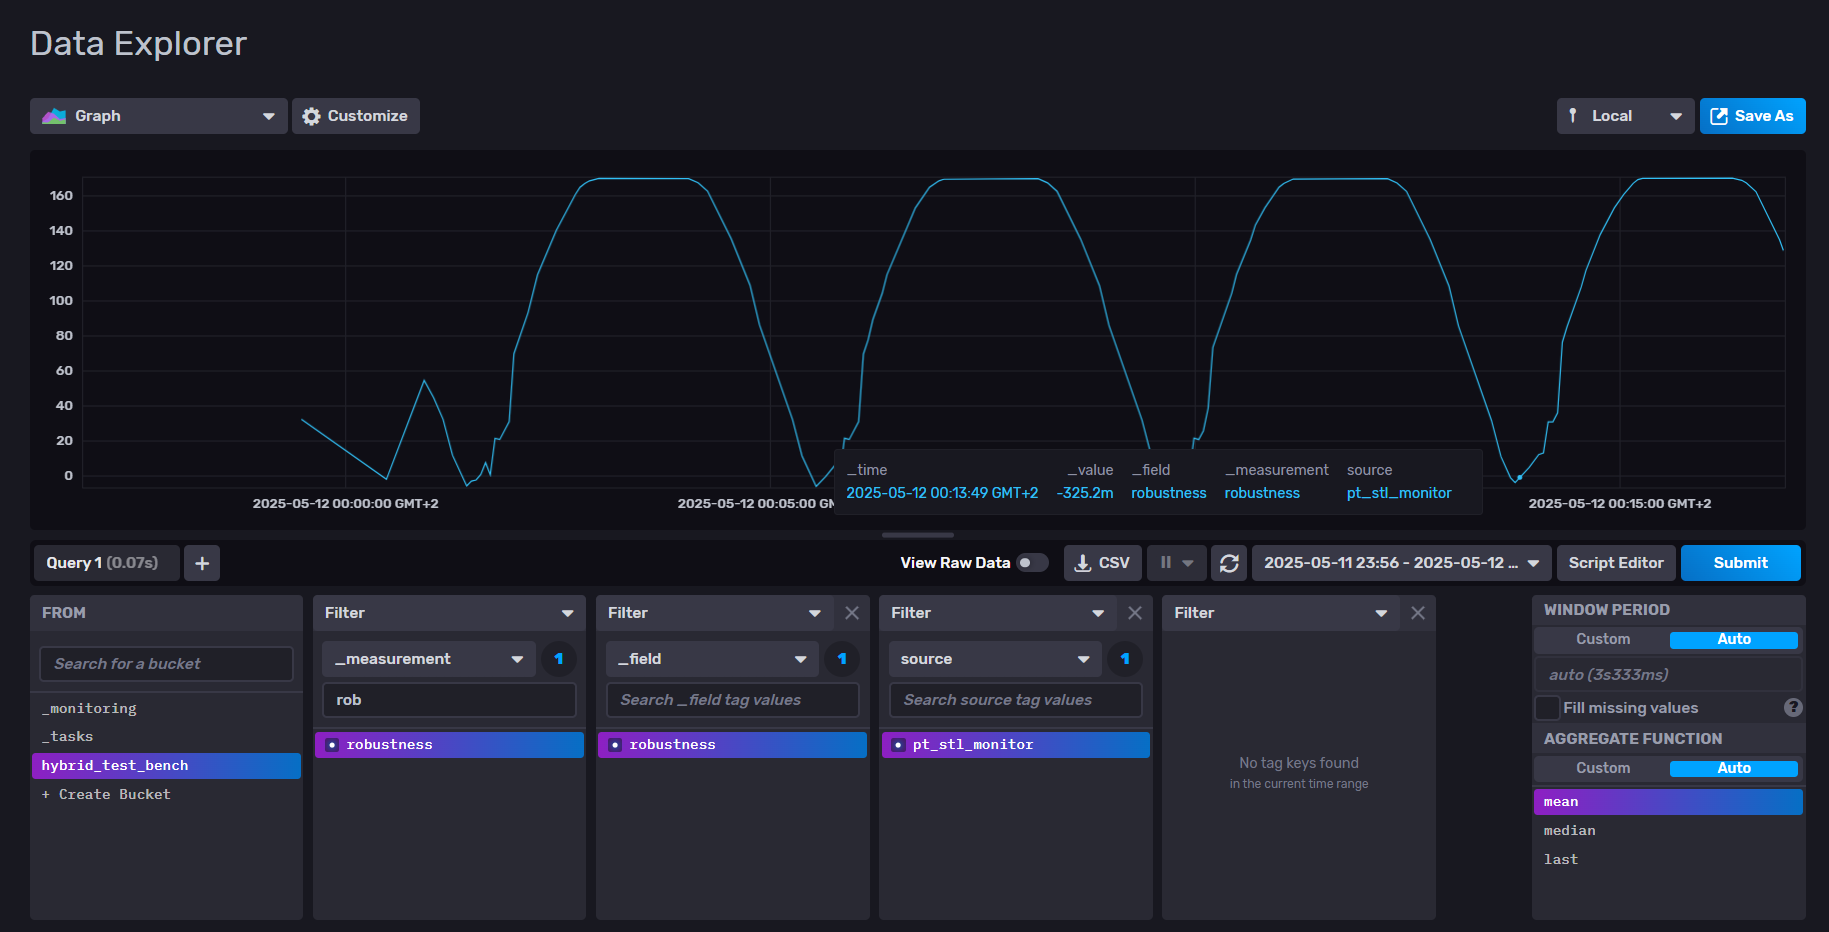
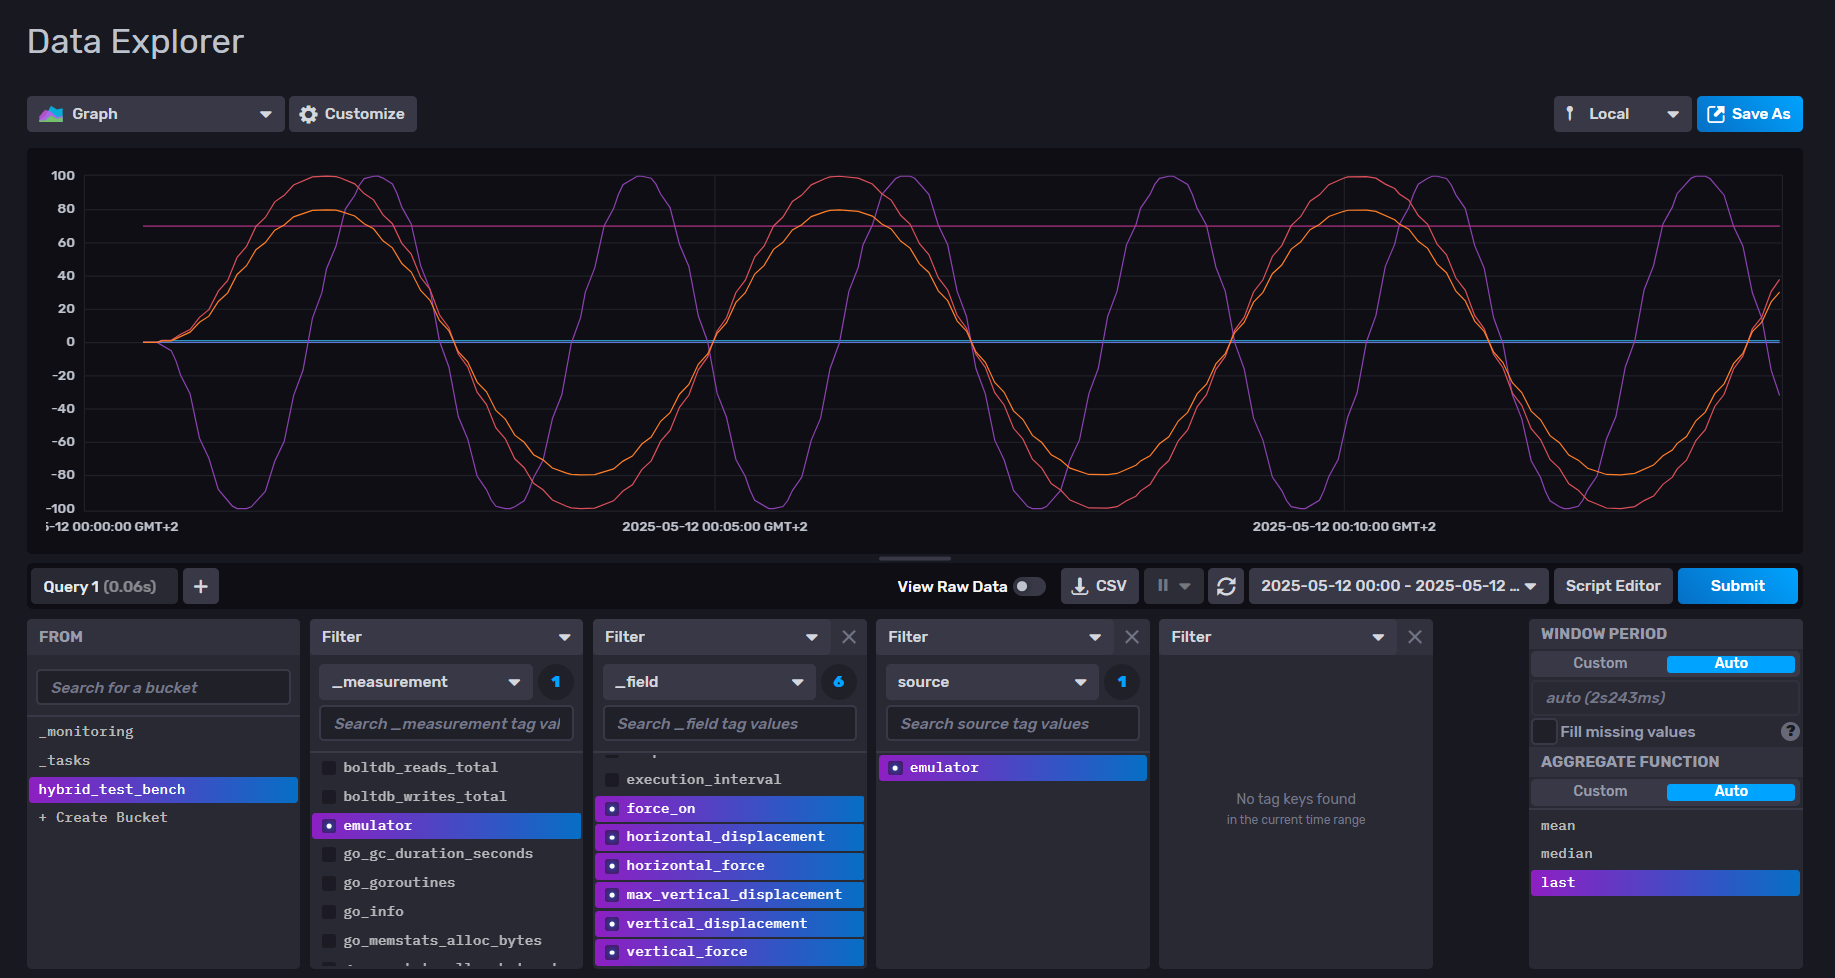

Here we will create a reconfiguration service.

In [ ]:
%%writefile pt_reconfiguration_service.py

# Configure python path to load the hybrid test bench modules
import sys
import os
import logging
import logging.config
import time
from influxdb_client import InfluxDBClient
from influxdb_client.client.write_api import SYNCHRONOUS
import rtamt

# Get the current working directory. Should be hybrid-test-bench.
current_dir = os.getcwd()

assert os.path.basename(current_dir) == 'hybrid-test-bench', 'Current directory is not hybrid-test-bench'

# Get the parent directory. Should be the root of the repository
parent_dir = current_dir

# The root of the repo should contain the startup folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'startup')), 'startup folder not found in the repository root'

# The root of the repo should contain the installation folder. Otherwise something went wrong during the inital setup.
assert os.path.exists(os.path.join(parent_dir, 'installation')), 'installation folder not found in the repository root'

bench_startup_dir = os.path.join(parent_dir, 'startup')

assert os.path.exists(bench_startup_dir), 'hybrid-test-bench startup directory not found'

# Add the parent directory to sys.path
sys.path.append(bench_startup_dir)

from communication.server.rabbitmq import Rabbitmq
from communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_FORCES

class PT_ReconfigurationService:

    def __init__(self, rabbitmq_config, influxdb_config):
        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        url = influxdb_config['url']
        token = influxdb_config['token']
        self._org = influxdb_config['org']
        self._bucket = influxdb_config['bucket']

        self._client = InfluxDBClient(url=url, token=token, org=self._org)

        self._l = logging.getLogger("PT_ReconfigurationService")

    def turn_off_forces(self):
        # Send a message to the PT to turn off the forces.
        with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
            rabbitmq.send_message(ROUTING_KEY_FORCES, {"forces": False})

        # Wait a bit for the message to be processed
        time.sleep(5)

    def check_robustness(self, robustness):
        # Check if the robustness is below a certain threshold.
        # If it is, send a message to the PT to reconfigure the system.
        threshold = 0.0
        for r in robustness:
            # Check if the robustness is below the threshold.
            if r[1] < threshold:
                # Here we will send a message that will turn off the forces
                self.turn_off_forces()

    def query_influxdb(self):
            # Define your Flux query: Query the relevant forces and displacements.
            # We set a stop time of -3s to ensure that the data is aligned from the different measurements.

            flux_query = f'''
                from(bucket: "{self._bucket}")
                |> range(start: -1h, stop: -3s)
                |> filter(fn: (r) => r["_measurement"] == "robustness")
                |> filter(fn: (r) => r["_field"] == "robustness")
                |> filter(fn: (r) => r["source"] == "pt_stl_monitor")
                |> aggregateWindow(every: 3s, fn: last, createEmpty: true)
                |> yield(name: "last")
            '''
            # Execute the query
            result = self._query_api.query(org=self._org, query=flux_query)

            robustness = []

            for table in result:
                for record in table.records:
                    ts = record.get_time().timestamp()
                    if record.get_field() == 'robustness':
                        robustness.append([ts, record.get_value()])

            return robustness
    
    def get_robustness(self, ch, method, properties, body_json):
    # Log the values received.
        self._l.info(f"Received state sample: {body_json}")
        
        # Get the displacement history from the influxdb, and process the displacement data into signals that ramt can understand.
        robustness = self.query_influxdb()

        self._l.debug(f"Robustness: {robustness}")

        self.check_robustness(robustness)

    def setup(self):
            self._rabbitmq.connect_to_server()

            # Initialize the Query API
            self._query_api = self._client.query_api()
            self._write_api = self._client.write_api(write_options=SYNCHRONOUS)

            # Subscribe to any message coming from the Hybrid Test Bench physical twin.
            self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                    on_message_callback=self.get_robustness)

            self._l.info(f"PT_ReconfigurationService setup complete.")

    def start_serving(self):
            self._rabbitmq.start_consuming()
        
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from pyhocon import ConfigFactory

    # Get logging configuration
    log_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'log.conf')
    logging.config.fileConfig(log_conf)

    # Get path to the startup.conf file used in the hybrid test bench PT & DT:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'hybrid-test-bench', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the hybrid test bench repository.
    config = ConfigFactory.parse_file(startup_conf)

    service = PT_ReconfigurationService(rabbitmq_config=config["rabbitmq"], influxdb_config=config["influxdb"])

    service.setup()
    
    # Start the PT_ReconfigurationService
    service.start_serving()

Overwriting pt_reconfiguration_service.py


Next, we have to run the reconfiguration service.
As a result, the force should turn off.

Run the following command in a new terminal to start the service: `python pt_reconfiguration_service.py`.